In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from decimal import Decimal, ROUND_HALF_UP
from matplotlib import pyplot as plt
from statistics import mode
from collections import Counter

In [2]:
from keras_vggface.vggface import VGGFace
from keras_vggface import utils
from keras.preprocessing import image
import tensorflow as tf

Thinning the dataframe

In [3]:
def new_list(l, count = 50):
    len_a = len(l)
    if count >= len_a:
        return l
    c = len_a / count
    res = []
    prev = 1
    cnt = 0
    for i in l:
        if prev >= len_a:
            break
        cnt += 1
        dec = int(Decimal(prev).to_integral_value(rounding = ROUND_HALF_UP))
        if cnt == dec:
            prev += c
            res.append(i)
    return res

In [4]:
# For every video, the deep embeddings are combined into sequences (windows) of 2 seconds.
# However, here we downsample every video to 5 frames per second (FPS). 
# That is, at 25 FPS, we select every 5 frame. 
# For 30 FPS, every 6 frames and so on.

df_test = pd.read_csv('img/01-01-07-02-02-02-06/df_test.csv')
name_folder = df_test.name_folder.unique().tolist()
fps = 30

need_index = []
for i in tqdm(name_folder):
    curr_name = i
    curr_df = df_test[df_test.name_folder==i]
    all_index = curr_df.index.tolist()
    need_frames = round(len(curr_df)/(5*fps/25))
    if need_frames!=0:
        need_index.extend(new_list(all_index, count = need_frames))
        
df_test_short = df_test[df_test.index.isin(need_index)]
df_test_short = df_test_short.reset_index(drop=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


In [5]:
df_test_short.head()

,name_folder,path_images,emotion
0,01-01-07-02-02-02-06,img/01-01-07-02-02-02-06/0/000001.jpg,5
1,01-01-07-02-02-02-06,img/01-01-07-02-02-02-06/0/000007.jpg,5
2,01-01-07-02-02-02-06,img/01-01-07-02-02-02-06/0/000013.jpg,5
3,01-01-07-02-02-02-06,img/01-01-07-02-02-02-06/0/000019.jpg,5
4,01-01-07-02-02-02-06,img/01-01-07-02-02-02-06/0/000025.jpg,5


Building of a model for feature extraction

In [6]:
path_model = 'models/EmoAffectnet/weights_66_37.h5'
resnet50_features = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
gaus = tf.keras.layers.GaussianNoise(0.1)(resnet50_features.output)
x = tf.keras.layers.Dense(units=512, kernel_regularizer=tf.keras.regularizers.l2(1e-4), activation = 'relu', name='dense_x')(gaus)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(7, activation = 'softmax')(x) 
model_resnet50_features = tf.keras.models.Model(resnet50_features.input, x)
model_resnet50_features.load_weights(path_model)
model_loaded = tf.keras.models.Model(inputs=model_resnet50_features.input, outputs=[model_resnet50_features.get_layer('dense_x').output])

Getting of features

In [7]:
def get_feature(path, model_loaded, shape = (224,224)):
    feature_all = []

    for i in tqdm(path):
        read_images = [] 
        for image_curr in i:
            img = image.load_img(image_curr, target_size=shape)
            x = image.img_to_array(img)
            x = x.reshape((1, x.shape[0], x.shape[1], x.shape[2]))
            x = utils.preprocess_input(x,version=2) # or version=2
            x = x.reshape(shape[0],shape[1],3)
            read_images.append(x)

        feature_all.append(model_loaded.predict(np.asarray(read_images)))
        
    return feature_all

def sequencing(df, unique_name, len_seq=10, step = 2):
    path_new = []
    name_new = []
    labels_new = []
    dict_seq_train = {}
    for i in tqdm(unique_name):
        curr_df = df[df.name_folder==i].copy()
        curr_df = curr_df.reset_index(drop=True)
        if len(curr_df) > len_seq:
            for j in range(0,len(curr_df), round(len_seq/step)):
                start = j # start of slice
                finish = j+len_seq # end of slice
                need_slice = curr_df.loc[start:finish-1]
                if len(need_slice) == len_seq:
                    path_new.append(need_slice.path_images.tolist())
                    name_new.append(need_slice.name_folder.tolist())
                    labels_new.append(need_slice.emotion.tolist())
                else:
                    need_duble =  len_seq - len(need_slice)
                    path_new.append(need_slice.path_images.tolist() + [curr_df.path_images.tolist()[-1]]*need_duble)
                    name_new.append(need_slice.name_folder.tolist() + [curr_df.name_folder.tolist()[-1]]*need_duble)
                    labels_new.append(need_slice.emotion.tolist() + [curr_df.emotion.tolist()[-1]]*need_duble)
        elif len(curr_df) == len_seq:
            path_new.append(curr_df.path_images.tolist())
            name_new.append(curr_df.name_folder.tolist())
            labels_new.append(curr_df.emotion.tolist())
            
        elif len(curr_df) < len_seq:
            need_duble =  len_seq - len(curr_df)
            path_new.append(curr_df.path_images.tolist() + [curr_df.path_images.tolist()[-1]]*need_duble)
            name_new.append(curr_df.name_folder.tolist() + [curr_df.name_folder.tolist()[-1]]*need_duble)
            labels_new.append(curr_df.emotion.tolist() + [curr_df.emotion.tolist()[-1]]*need_duble)
            
    return path_new, name_new, labels_new

Getting of data for input LSTM

In [8]:
path_new, name_new, labels_new = sequencing(df_test_short, name_folder, len_seq=10, step = 2)

feature = get_feature(path_new, model_loaded)
feature_ar = np.asarray(feature)
feature_ar.shape

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:11<00:00,  2.77s/it]


(4, 10, 512)

Building of a model

In [9]:
def network():
    input_lstm = tf.keras.Input(shape=(10, 512))
    X = tf.keras.layers.Masking(mask_value=0.)(input_lstm)
    X = tf.keras.layers.LSTM(512, return_sequences = True, kernel_regularizer=tf.keras.regularizers.l2(1e-3))(X)
    X = tf.keras.layers.Dropout(rate = 0.2)(X)
    X = tf.keras.layers.LSTM(256, return_sequences = False, kernel_regularizer=tf.keras.regularizers.l2(1e-3))(X)
    X = tf.keras.layers.Dropout(rate = 0.2)(X)
    X = tf.keras.layers.Dense(units = 7)(X)
    X = tf.keras.layers.Activation('softmax')(X)
    model = tf.keras.Model(inputs=input_lstm, outputs=X)
    return model

Getting of prediction

In [10]:
def cout_prob(emotion_count, proby, i):
    if type(proby[i]) == int:
        emotion_count[proby[i]] += 1
    else:
        emotion_count += proby[i] 
    return emotion_count
    
def get_predy_truey(name_x_new, truey, proby):
    emotion_count = np.zeros((7))
    list_true = []
    list_proby = []
    name = None
    name_list = []
    for i in range(len(name_x_new)):
        if name == None:
            name = name_x_new[i][0]
            true = truey[i]
            emotion_count = cout_prob(emotion_count, proby, i)
            
        elif name_x_new[i][0] == name:
            emotion_count = cout_prob(emotion_count, proby, i)
            
        elif name_x_new[i][0] != name:
            list_true.append(true) 
            list_proby.append(emotion_count/np.sum(emotion_count))
            name = name_x_new[i][0]
            emotion_count = np.zeros((7))
            true = truey[i]
            emotion_count = cout_prob(emotion_count, proby, i)
            
        if i == len(name_x_new)-1:
            list_true.append(true) 
            list_proby.append(emotion_count/np.sum(emotion_count))

    list_true = np.asarray(list_true)
    pred_max = np.argmax(list_proby, axis = 1).tolist()

    return list_true, pred_max

In [11]:
# RAVDESS, CREMA-D, RAMAS, IEMOCAP and SAVEE corpora have one emotion label during all interval.
# Label -1 is in Affwild2 corpora

def change_labels(labels):
    counter = Counter(labels)
    if len(counter) > 1:
        try:
            if int(mode(labels)) == -1:
                curr_mode = int(sorted(counter, key=counter.get, reverse=True)[1])
            else:
                curr_mode = int(mode(labels))
        except:
            if int(sorted(counter, key=counter.get, reverse=True)[0]) == -1:
                curr_mode = int(sorted(counter, key=counter.get, reverse=True)[1])
            else:
                curr_mode = int(sorted(counter, key=counter.get, reverse=True)[0])
    else:
        curr_mode = int(mode(labels))
    return curr_mode

In [12]:
model = network()
model.load_weights('models/LSTM/for_RAVDESS.h5')
prob = model.predict(feature_ar)

In [13]:
labels_true = []
for i in labels_new:
    labels_true.append(change_labels(i))

In [14]:
label_model = {0:'Neutral', 1:'Happiness', 2:'Sadness', 3:'Surprise', 4:'Fear', 5:'Disgust', 6:'Anger'}
truey, predy = get_predy_truey(name_new, labels_true, prob)
print('Ground truth: ', label_model[truey[0]])
print('Prediction class: ', label_model[predy[0]])

Ground truth:  Disgust
Prediction class:  Disgust


Drawing of face areas

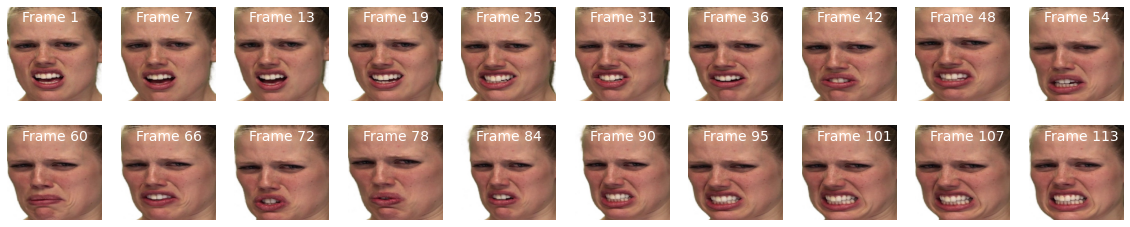

In [15]:
fig = plt.figure(figsize=(20, 4))

for i in range(20):
    ax = fig.add_subplot(2, 10, 1+i, xticks=[], yticks=[])
    frame = int(os.path.basename(df_test_short.path_images[i]).split('.')[0])
    img = image.load_img(df_test_short.path_images[i], target_size=(224,224))
    ax.imshow(img)
    ax.text(35, 35, 'Frame {}'.format(frame), fontsize = 14, color = 'white')
    ax.axis('off')
plt.show()